In [1]:
import SimpleITK as sitk
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torchio.transforms import Affine

In [2]:
def getLandmarksFromTXTFile(file, split=','):
    """
    Extract each landmark point line by line from a text file, and return
    vector containing all landmarks.
    """
    with open(file) as fp:
        landmarks = []
        for i, line in enumerate(fp):
            landmarks.append([float(k) for k in line.split('\n')[0].split(split)])
        landmarks = np.asarray(landmarks).reshape((-1, 3))
        return landmarks

Original shape (340, 284, 320)


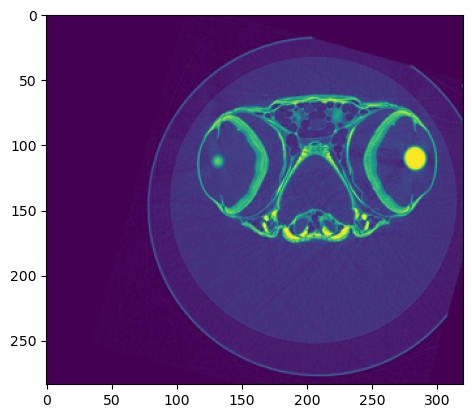

Transopsed shape (340, 284, 320)
Rotated shape (340, 284, 320)


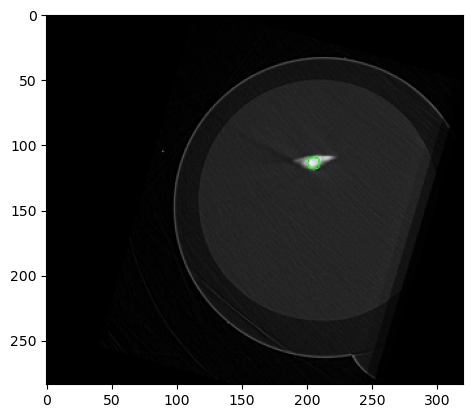

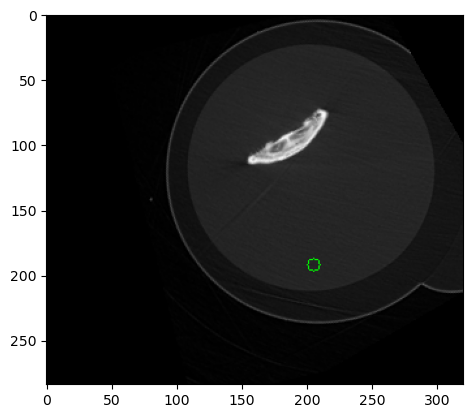

In [15]:
# affine transform
rotation_degrees = [30, 0, 0]
translations = [0, 0, 0]

rotation_radians = np.radians(rotation_degrees).tolist()
img_rotation = Affine(scales=[1.0, 1.0, 1.0], degrees=rotation_degrees, translation=translations, center='image')
pos_rotation = sitk.Euler3DTransform()
pos_rotation.SetRotation(*rotation_radians)
pos_rotation.SetTranslation(translations)

# data
img_path = 'c:\\Users\\fe0968\\Documents\\data\\medaka\\landmarks\\test_reference_1263_94-1_scale2_crop.tif'
#'/home/ws/ml0077/work/rl-medical/src/data/images/ADNI_002_S_0816_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070217005829488_S18402_I40731_Normalized_to_002_S_0295.nii.gz'
#landmark_path = '/home/ws/ml0077/work/rl-medical/src/data/landmarks_test2/test_5_landmarks.xlsx'#'/home/ws/ml0077/work/rl-medical/src/data/landmarks/ADNI_002_S_0816_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070217005829488_S18402_I40731.txt'
sitk_image = sitk.ReadImage(img_path, sitk.sitkUInt8)
np_image = sitk.GetArrayFromImage(sitk_image)

print('Original shape', np_image.shape)
plt.imshow(np_image[100])
plt.show()

# threshold image between p10 and p98 then re-scale [0-255]
if False:
    p0 = np_image.min().astype('float')
    p10 = np.percentile(np_image, 10)
    p99 = np.percentile(np_image, 99)
    p100 = np_image.max().astype('float')
    sitk_image = sitk.Threshold(sitk_image,
                                lower=p10,
                                upper=p100,
                                outsideValue=p10)
    sitk_image = sitk.Threshold(sitk_image,
                                lower=p0,
                                upper=p99,
                                outsideValue=p99)
    sitk_image = sitk.RescaleIntensity(sitk_image,
                                       outputMinimum=0,
                                       outputMaximum=255)

# Convert from [depth, width, height] to [height, width, depth]
#image_data = sitk.GetArrayFromImage(sitk_image).transpose(2, 1, 0).astype('uint8')
image_data = sitk.GetArrayFromImage(sitk_image).astype('uint8')

print('Transopsed shape', image_data.shape)

# rotate image
image_rotated = img_rotation(np.expand_dims(image_data, axis=0))[0]
#image_rotated = img_rotation(image_data)
print('Rotated shape', image_rotated.shape)

# rotate landmark
image_dims = np.shape(image_data)
#all_landmarks = getLandmarksFromTXTFile(landmark_path, split=",")
all_landmarks = [[410/2, 228/2, 21/2],[418/2, 170/2, 584/2]]
test_lm = all_landmarks[0]
center = [(image_dims[0] - 1) / 2, (image_dims[1] - 1) / 2 - 1, (image_dims[2] - 1) / 2]
pos_rotation.SetCenter(center)
test_lm_rotated = pos_rotation.TransformPoint(test_lm)

# visualization
#sl = image_data[:, :, int(test_lm[2])].astype(np.uint8)
sl = image_data[int(test_lm[2]), :, :].astype(np.uint8)
sl_color = cv2.cvtColor(sl, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_color, (int(test_lm[0]), int(test_lm[1])), 5, (0, 255, 0))

#sl_rotated = image_rotated[:, :, int(test_lm_rotated[2])].astype(np.uint8)
sl_rotated = image_rotated[int(test_lm_rotated[2]), :, :].astype(np.uint8)
sl_rotated_color = cv2.cvtColor(sl_rotated, cv2.COLOR_GRAY2RGB)
cv2.circle(sl_rotated_color, (int(test_lm_rotated[0]), int(test_lm_rotated[1])), 5, (0, 255, 0))

plt.imshow(sl_color)
plt.show()
plt.imshow(sl_rotated_color)
plt.show()
